In [20]:
import warnings
warnings.filterwarnings("ignore")

import re
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter

# Modèle de Cox à Hasards Proportionnels - Explicabilité
## Import des données

In [21]:
df = pd.read_csv('../data/df_duree.csv',sep = ',')

In [22]:
df['arrete'] = pd.to_datetime(df['arrete']) 
df['date_entree_defaut'] = pd.to_datetime(df['date_entree_defaut']) 

## Sélection des variables d'intérêts

In [23]:
df['ANC_PRO_MAX_PFI_2'] = df['ANC_PRO_MAX_PFI_2'].apply(lambda x : 1 if x == '(-inf, 30.50)' else 2 if x == '[30.50, 68.50)' else 3 if x == '[68.50, 151.50)' else 4)

df['MT_REST_VIVRE'] = df['MT_REST_VIVRE'].apply(lambda x : 1 if x == '[2418.50, inf)' else 2 )

In [24]:
df = df[['CP','MTF', 'dls_mep_entree_def','ANC_PRO_MAX_PFI_2','nb_empr_ope','MT_REST_VIVRE','DET', 'arrete', 'cd_op','date_entree_defaut']]

### Split des données : Entraînement / Validation

In [25]:
df_validation = df[df['arrete']>"2020-06-30"]
data_train = df[df['arrete']<"2020-01-30"]

### Création des variables modélisant le temps passé pour le modèle

In [26]:
data_train['start'] = 0
data_train['stop'] = data_train['arrete'] - data_train['date_entree_defaut']
data_train['stop'] = data_train['stop'].dt.days

df_validation['start'] = 0
df_validation['stop'] = df_validation['arrete'] - df_validation['date_entree_defaut']
df_validation['stop'] = df_validation['stop'].dt.days

In [27]:
data_train['id'] = data_train['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))
df_validation['id'] = df_validation['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))

In [28]:
data_train.id = data_train.id.astype('int')

In [29]:
data_train.loc[(data_train['start'] == data_train['stop']) & (data_train['start'] == 0) & data_train['DET'], 'stop'] = 0.5  # car le modele n'accepte pas les individus qui sortent de la survie au moment ou ils y entrent donc on remplace les 0 par 0.5.

df_validation.loc[(df_validation['start'] == df_validation['stop']) & (df_validation['start'] == 0) & df_validation['DET'], 'stop'] = 0.5 

In [30]:
data_train = data_train.select_dtypes(exclude=["datetime64"])
df_validation = df_validation.select_dtypes(exclude=["datetime64"])

In [31]:
data_train.drop(columns = ["cd_op"], inplace = True)
df_validation.drop(columns = ["cd_op"], inplace = True)

In [32]:
data_train.shape

(9842, 10)

In [33]:
data_train.columns

Index(['CP', 'MTF', 'dls_mep_entree_def', 'ANC_PRO_MAX_PFI_2', 'nb_empr_ope',
       'MT_REST_VIVRE', 'DET', 'start', 'stop', 'id'],
      dtype='object')

# Modelisation

In [35]:
df_validation.drop(columns = ['start','DET', 'id'],inplace = True )

In [36]:
cph = CoxPHFitter(penalizer=0.1,)  
cph.fit(data_train.drop(columns = ['id','start']), duration_col='stop', event_col='DET', show_progress = True)

Iteration 1: norm_delta = 3.92e-01, step_size = 0.9500, log_lik = -33154.89325, newton_decrement = 4.18e+02, seconds_since_start = 0.1
Iteration 2: norm_delta = 9.35e-02, step_size = 0.9500, log_lik = -32725.45569, newton_decrement = 1.28e+01, seconds_since_start = 0.1
Iteration 3: norm_delta = 1.48e-02, step_size = 0.9500, log_lik = -32712.03009, newton_decrement = 2.59e-01, seconds_since_start = 0.2
Iteration 4: norm_delta = 2.15e-04, step_size = 1.0000, log_lik = -32711.76821, newton_decrement = 5.31e-05, seconds_since_start = 0.3
Iteration 5: norm_delta = 4.41e-08, step_size = 1.0000, log_lik = -32711.76815, newton_decrement = 2.23e-12, seconds_since_start = 0.3
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 9842 total observations, 5742 right-censored observations>

### Prédictions

In [38]:
predictions = cph.predict_survival_function(df_validation)

In [39]:
predictions = predictions.transpose()

In [40]:
predictions.shape

(11492, 996)

In [43]:
cph.check_assumptions(data_train.drop(columns = ['id','start']))

Proportional hazard assumption looks okay.


[]

In [44]:
cph.AIC_partial_

65435.53630594079

In [45]:
cph.concordance_index_

0.64565578297633

On obtient 0.65 de concordance des index qui est une mesure similaire à l'AUC. 

### Courbes de Survie

<Axes: >

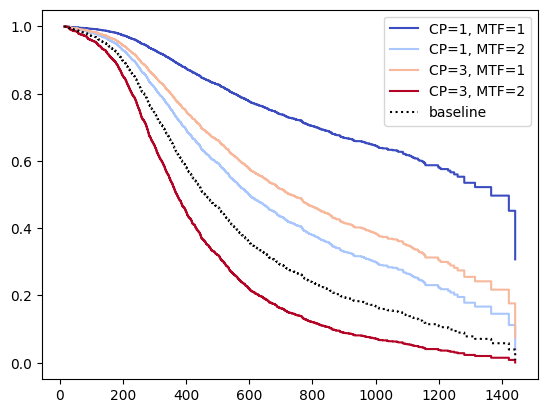

In [46]:
cph.plot_partial_effects_on_outcome(['CP','MTF'], values=[ [1,  1], [1,  2], [3, 1], [3,  2]], cmap='coolwarm')

<Axes: >

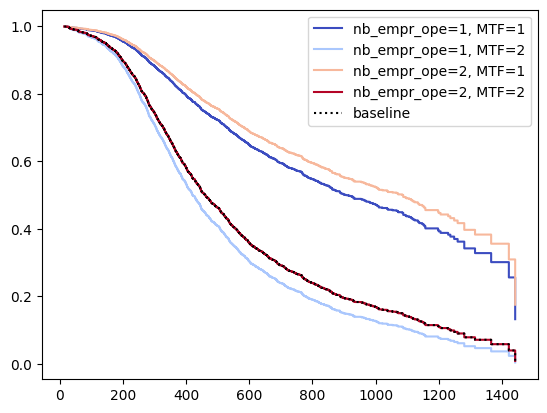

In [49]:
cph.plot_partial_effects_on_outcome(['nb_empr_ope','MTF'], values=[ [1,  1], [1,  2], [2, 1], [2,  2]], cmap='coolwarm')

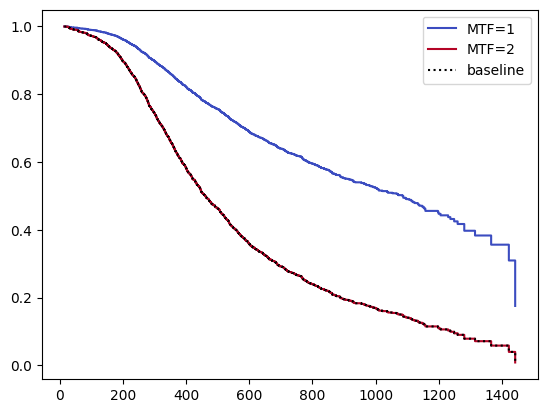

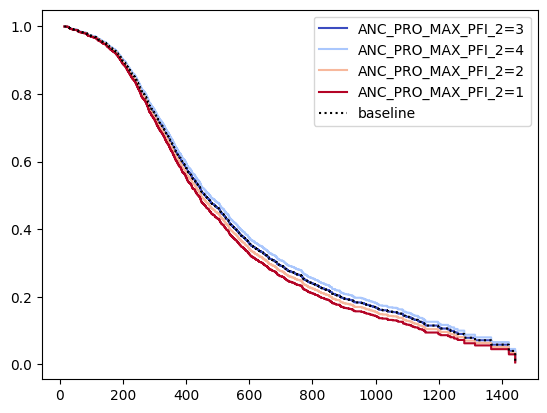

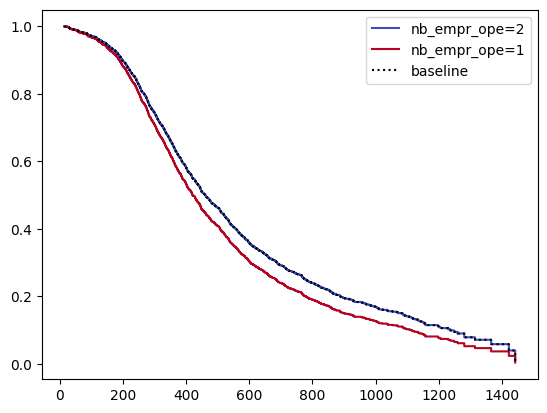

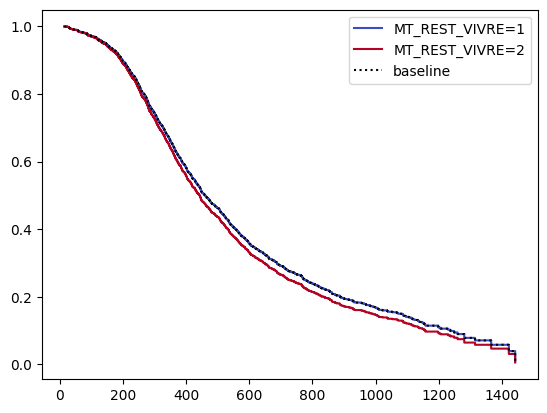

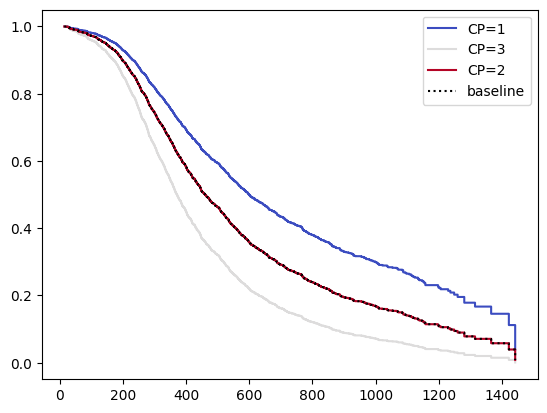

In [47]:
for col in data_train[['MTF','ANC_PRO_MAX_PFI_2','nb_empr_ope','MT_REST_VIVRE','CP']].columns:
    cph.plot_partial_effects_on_outcome(col, values=data_train[col].unique(), cmap='coolwarm')